# Qiskit tests
## Creation of a circuit that implements HHL for Toeplitz symmetrical tridiagonal matrix 

This notebook is based in 2 papers:

- [1] : Harrow, A. W., Hassidim, A., Lloyd, S. (2009). Quantum algorithm for linear systems of equations. Phys. Rev. Lett. 103, 15 (2009), 1–15. <https://doi.org/10.1103/PhysRevLett.103.150502>
- [2] : Carrera Vazquez, A., Hiptmair, R., & Woerner, S. (2020). Enhancing the Quantum Linear Systems Algorithm using Richardson Extrapolation.arXiv:2009.04484 <http://arxiv.org/abs/2009.04484>`

The code is mostly based in the original code for the HHL solver in Qiskit-Algorithms

In [1]:
import numpy as np
from typing import Optional
from qiskit import QuantumCircuit, QuantumRegister, AncillaRegister, transpile, ClassicalRegister
from qiskit.circuit.library import PhaseEstimation
from qiskit.circuit.library.arithmetic.piecewise_chebyshev import PiecewiseChebyshev  
from qiskit.circuit.library.arithmetic.exact_reciprocal import ExactReciprocal
from numpy_matrix import NumPyMatrix
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator

1. Build circuit
2. Build observables [2]

In [2]:
def get_delta(n_l: int, lambda_min: float, lambda_max: float) -> float:
    """Calculates the scaling factor to represent exactly lambda_min on nl binary digits.

    Args:
        n_l: The number of qubits to represent the eigenvalues.
        lambda_min: the smallest eigenvalue.
        lambda_max: the largest eigenvalue.

    Returns:
        The value of the scaling factor.
    """
    formatstr = "#0" + str(n_l + 2) + "b"
    lambda_min_tilde = np.abs(lambda_min * (2 ** n_l - 1) / lambda_max)
    # floating point precision can cause problems
    if np.abs(lambda_min_tilde - 1) < 1e-7:
        lambda_min_tilde = 1
    binstr = format(int(lambda_min_tilde), formatstr)[2::]
    lamb_min_rep = 0
    for i, char in enumerate(binstr):
        lamb_min_rep += int(char) / (2 ** (i + 1))
    return lamb_min_rep


In [3]:
def calculate_norm(qc: QuantumCircuit) -> float:
        """Calculates the value of the euclidean norm of the solution.

        Args:
            qc: The quantum circuit preparing the solution x to the system.

        Returns:
            The value of the euclidean norm of the solution.
        """
        # Calculate the number of qubits
        nb = qc.qregs[0].size
        nl = qc.qregs[1].size
        na = qc.num_ancillas

        # Create the Operators Zero and One
        # Pauli Strings

        # I = Identity
        # Z = Z-Gate
        
        zero_op = (I + Z) / 2
        one_op = (I - Z) / 2

        # Norm observable
        observable = one_op ^ TensoredOp((nl + na) * [zero_op]) ^ (I ^ nb)
        norm_2 = (~StateFn(observable) @ StateFn(qc)).eval()

        return np.real(np.sqrt(norm_2) / self.scaling)

In [133]:
#Function to build the HHL circuit
def build_circuit(matrix, vector, tolerance: float, flag: bool, meas: bool = False):
    """
    Builds the HHL circuit using the required args
    
    Args:
        `matrix`: The matrix that defines the linear system, i.e. A in Ax = b.
        `vector`: The right-hand side of the equation, i.e. b in Ax = b.
        `tolerance`: Tolerance of the solution bounds. This value is used to define the 3 tolerances needed for the HHL [2] equation (62).
        `flag`: Flag deciding whether the reciprocal circuit is or not exact
        `meas`: Flag deciding whether measures are made in the non x qubits
        
    Returns:
        The HHL circuit
    
    Raises:
        ValueError: If the data is not in the right format
        ValueError: The matrix dimension is not correct
    """
    
    # Define the tolerances of the circuit
    epsilon_a = tolerance/6
    epsilon_r = tolerance/3
    epsilon_s = tolerance/3
    
    # We need an np.array to write the values to the register
    if isinstance(vector,(list,np.ndarray)):
        if isinstance(vector,list):
            vector = np.array(vector)    
        # We define the number of needed qubits and insert the vector to the register
        nb = int(np.log2(len(vector)))
        vector_circuit = QuantumCircuit(nb)
        vector_circuit.initialize(vector / np.linalg.norm(vector), list(range(nb)), None)
    else:
        raise ValueError(f"Invalid type for vector: {type(vector)}.")
    
    # Define flag, if 1, correct solution, if 0, incorrect
    nf = 1
    
    # Input the matrix A for the QPE
    if isinstance(matrix, (list, np.ndarray)):
        if isinstance(matrix, list):
            matrix = np.array(matrix)

        if matrix.shape[0] != matrix.shape[1]:
            raise ValueError("Input matrix must be square!")
        
        if np.log2(matrix.shape[0]) % 1 != 0:
            raise ValueError("Input matrix dimension must be 2^n!")
        
        if not np.allclose(matrix, matrix.conj().T):
            raise ValueError("Input matrix must be hermitian!")
        
        if matrix.shape[0] != 2 ** vector_circuit.num_qubits:
            raise ValueError(
                "Input vector dimension does not match input "
                "matrix dimension! Vector dimension: "
                + str(vector_circuit.num_qubits)
                + ". Matrix dimension: "
                + str(matrix.shape[0])
            )
        # We default to a TridiagonalToeplitz matrix, but in a general case we would use a more general library
        # Also, we want the evolution_time to be 2pi/\landa_{max}, but we update it after, when we have the eigenvalues of the matrix
        matrix_circuit = NumPyMatrix(matrix,evolution_time=2 * np.pi, tolerance=epsilon_a)
        
        # General case
        # matrix_circuit = NumPyMatrix(matrix, evolution_time=2 * np.pi)
        
    else:
        raise ValueError(f"Invalid type for matrix: {type(matrix)}.")
    
    # Define condition and eigenvalue bounds    
    if (hasattr(matrix_circuit, "condition_bounds")):
        kappa = matrix_circuit.condition_bounds()[1]
    else:
        kappa = 1
    # Using kappa, the condition bound,  we define nl, the number of qubits needed to represent the eigenvalues
    nl = max(nb+1,int(np.log2(kappa))+1)
    
    # Define eigenvalues
    if hasattr(matrix_circuit, "eigs_bounds"):
        lambda_min, lambda_max = matrix_circuit.eigs_bounds()
        
        # Constant so that the minimum eigenvalue is represented exactly, since it contributes
        # the most to the solution of the system
        delta = get_delta(nl, lambda_min, lambda_max)
        # Update evolution time
        matrix_circuit.evolution_time = 2 * np.pi * delta / lambda_min
        # Update the scaling of the solution
        scaling = lambda_min
    else:
        delta = 1 / (2 ** nl)
        print("The solution will be calculated up to a scaling factor.")
    
        
    # Define the reciprocal circuit
    
    # # Using an exact reciprocal circuit
    if flag:
        reciprocal_circuit = ExactReciprocal(nl, delta)
        # Update number of ancilla qubits
        na = matrix_circuit.num_ancillas
    
    # Using Chebyshev interpolation to approximate arcsin(C/x) to a degree of degree
    else: 
        # Calculate breakpoints for the reciprocal approximation
        num_values = 2 ** nl
        constant = delta
        # a as [2] indicates
        
        # No tengo para nada claro esto, no encuentro que hay que hacer con la a para pasarla a entero
        a = int(2**(2*nl/3))  # pylint: disable=invalid-name

        # Calculate the degree of the polynomial and the number of intervals
        r = 2 * constant / a + np.sqrt(np.abs(1 - (2 * constant / a) ** 2))
        degree = min(nb,int(np.log(1+(16.23* np.sqrt(np.log(r) ** 2 + (np.pi / 2) ** 2)* kappa* (2 * kappa - epsilon_r))/ epsilon_r)),)
        # As [2]
        num_intervals = int(np.ceil(np.log((num_values - 1) / a) / np.log(5)))

        # Calculate breakpoints and polynomials
        breakpoints = []
        for i in range(0, num_intervals):
            # Add the breakpoint to the list
            breakpoints.append(a * (5 ** i))

            # Define the right breakpoint of the interval
            if i == num_intervals - 1:
                breakpoints.append(num_values - 1)
        # Once we have the intervals, and everything is defined, we can make an approximation by a polynomial function of degree
        reciprocal_circuit = PiecewiseChebyshev(
            lambda x: np.arcsin(constant / x), degree, breakpoints, nl, name="c_Rot"
        )
        # Number of ancilla qubits
        na = max(matrix_circuit.num_ancillas, reciprocal_circuit.num_ancillas)
        
    # Construction of the circuit
    
    # Initialise the quantum registers
    qb = QuantumRegister(nb,name="b")  # right hand side and solution
    ql = QuantumRegister(nl,name="0")  # eigenvalue evaluation qubits
    if na > 0:
        qa = AncillaRegister(na,name="anc")  # ancilla qubits
    qf = QuantumRegister(nf,name="flag")  # flag qubits

    if na > 0:
        qc = QuantumCircuit(qb, ql, qa, qf)
    else:
        qc = QuantumCircuit(qb, ql, qf)

    # State preparation
    qc.append(vector_circuit, qb[:])
    qc.barrier(label="\u03C0_1")
    # QPE
    phase_estimation = PhaseEstimation(nl, matrix_circuit)
    if na > 0:
        qc.append(phase_estimation, ql[:] + qb[:] + qa[: matrix_circuit.num_ancillas])
    else:
        qc.append(phase_estimation, ql[:] + qb[:])
    qc.barrier(label="\u03C0_2")
    # Conditioned rotation
    if flag:
        qc.append(reciprocal_circuit, ql[::-1] + [qf[0]])
    else:
        qc.append(
            reciprocal_circuit.to_instruction(),
            ql[:] + [qf[0]] + qa[: reciprocal_circuit.num_ancillas],
        )
    
    qc.barrier(label="\u03C0_3")
    # QPE inverse
    if na > 0:
        qc.append(phase_estimation.inverse(), ql[:] + qb[:] + qa[: matrix_circuit.num_ancillas])
    else:
        qc.append(phase_estimation.inverse(), ql[:] + qb[:])
    
    if meas:
        qc.measure_all()
    return qc

In [113]:
# Calc observables
def calc_observables(qc: QuantumCircuit, observable: Optional[int] = 3):
    """Calculates the value of the observable(s) given.

        Args:
            `qc`: The quantum circuit preparing the solution x to the system.
            # TODO
            # Not yet implemented
            `observable`: Information to be extracted from the solution. 1 - ||x'||, 2 - F_b(x), 3 - Average solution
            `post_processing`: Function to compute the value of the observable.

        Returns:
            The value of the observable(s) and the circuit results before post-processing as a tuple.
        """
    nb = qc.qregs[0].size
    nl = qc.qregs[1].size
    na = qc.num_ancillas
    
    
    
    return solution

In [114]:
# Solve circuit
def solve(qc: QuantumCircuit):
    
    return solution

In [115]:
def tridiag_matrix(diag,up,n) -> np.ndarray:
    """Returns a tridiagonal symmetrical matrix
    
    Args:
        `diag`: Value of the diagonal
        `up`: Value of the subdiagonals
        `n`: Size of the matrix
    
    Returns:
        The matrix
    """
    if n<2: 
        raise ValueError("The dimension of the matrix must be greater than 2")
    
    rows = []
    
    for i in range(n):
        row = np.zeros(n)
        if i>0:
            row[i-1]=up
        row[i]=diag
        if i<n-1:
            row[i+1]=up
            
        rows.append(row)
        
    matrix = np.array(rows)
    return matrix

In [116]:
def create_observable(qc: QuantumCircuit):
    nb = qc.qregs[0].size
    nl = qc.qregs[1].size
    na = qc.num_ancillas
    
    zero_op = np.array([[1,0],[0,0]])
    one_op = np.array([[0,0],[0,1]])
    t_zero= zero_op
    t_one = one_op
    
    for _ in range(nl+na):
        t_zero = np.kron(t_zero,zero_op)
        
    for _ in range(nb):
        t_one = np.kron(t_one,one_op)
        
    observable = np.kron(t_one,np.kron(t_zero,t_one))
    return observable

In [117]:
def calculate_expectation_value_from_counts(counts, observable):
    expectation_value = 0
    total_shots = sum(counts.values())
    
    for outcome, count in counts.items():
        prob = count / total_shots
        # Convert binary string outcome to integer
        outcome_index = int(outcome, 2)
        # Extract the diagonal element corresponding to the outcome
        expectation_value += prob * observable[outcome_index, outcome_index]
    
    return expectation_value

In [118]:
nb = hhl.qregs[0].size
nl = hhl.qregs[1].size
na = hhl.num_ancillas
zero_op = np.array([[1,0],[0,0]])
one_op = np.array([[0,0],[0,1]])
t = zero_op
for _ in range(nl+na):
    t = np.kron(t,zero_op)
    

---
### **Celda de pruebas**

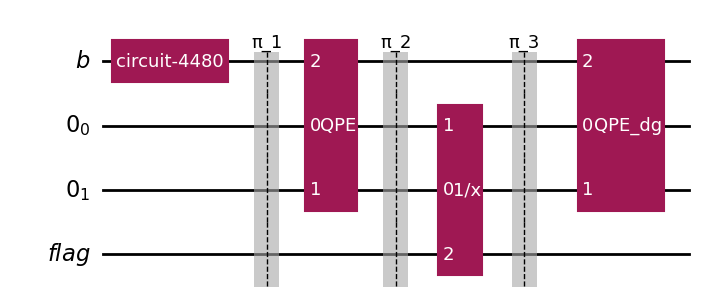

In [143]:
vector = np.array([1,0])
matrix = tridiag_matrix(1,-1/3,2)

hhl = build_circuit(matrix,vector,10e-2,True)
hhl.draw('mpl')


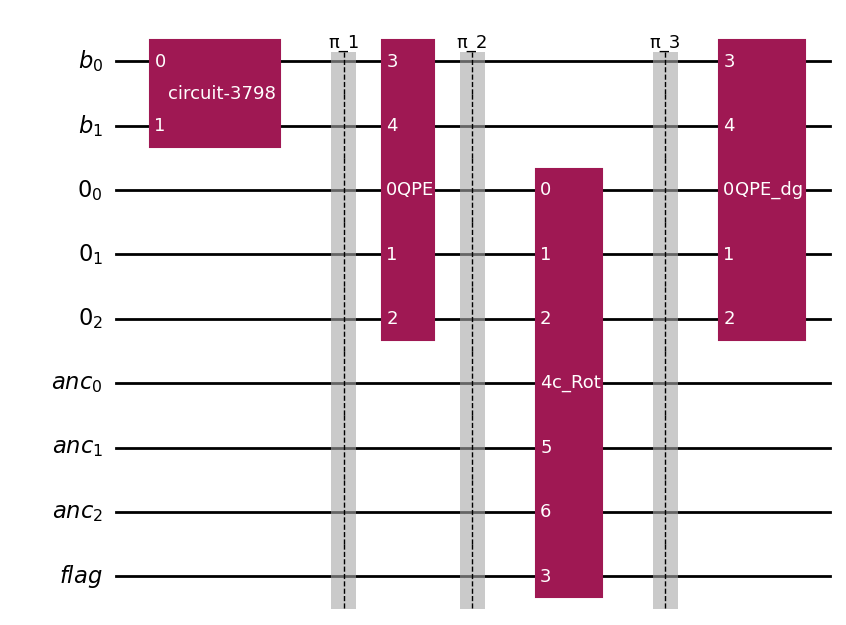

In [120]:
vector = np.array([1,0,1,0])
matrix = tridiag_matrix(1,-1/3,4)
hhl = build_circuit(matrix,vector,10e-2,False,False)
hhl.draw('mpl')

-----
We can test the circuit using statevectors

In [145]:
statevector = Statevector(hhl)
st=np.array(statevector)
num = int(len(st)/2)
sol = np.array([st[num],st[(num+1)]]).real
sol / np.linalg.norm(sol)

array([0.9486833 , 0.31622777])

In [125]:
statevector = Statevector(hhl)
st=np.array(statevector)
num = int(len(st)/2)
sol = np.array([st[num],st[(num+1)],st[num+2],st[num+3]]).real
sol / np.linalg.norm(sol)

array([ 0.78780022, -0.61593086,  0.        ,  0.        ])

Exact solution

In [126]:
sol=np.linalg.solve(matrix,vector/np.linalg.norm(vector))
sol/np.linalg.norm(sol)
norm=np.sqrt(sum(sol**2))

sol/norm

array([0.9486833 , 0.31622777])

If we have a 2-dimensional vector, the solution with statevectors is exact (we only have one qubit for $b$). But as we increase the dimension, the solution worsens

-----
## Prueba con shots

Counts for circuit : {'1000': 4516, '0000': 1556, '1001': 524, '0001': 1596}
Real: 0.9486832980505138|0> + 0.31622776601683794|1>
Filtered Counts: {'1000': 4516, '1001': 524}
Conditional Probabilities of the First Qubit: {'0': 0.7412109375, '1': 0.2587890625}


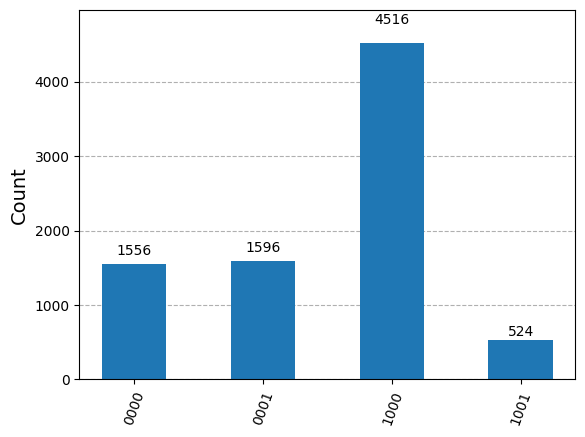

In [138]:
from qiskit_aer.primitives import SamplerV2

sim = AerSimulator()
hhl_meas = build_circuit(matrix,vector,10e-2,True,True)
hhl_meas = transpile(hhl_meas,sim)

sampler = SamplerV2()

job = sampler.run([hhl_meas],shots=8192)
job_result = job.result()
counts=job_result[0].data.meas.get_counts()
print(f"Counts for circuit : {job_result[0].data.meas.get_counts()}")
print(f"Real: {3/np.sqrt(10)}|0> + {1/np.sqrt(10)}|1>")

filtered_counts = {k: v for k, v in job_result[0].data.meas.get_counts().items() if k[0] == '1'}
total_filtered_counts = sum(filtered_counts.values())
prob_amplitudes = { '0': 0, '1': 0 }

for outcome, count in counts.items():
    first_qubit_state = outcome[-1]  # Get the state of the first qubit
    prob_amplitudes[first_qubit_state] += count / 8192
    

obs=create_observable(hhl)    
norm2=calculate_expectation_value_from_counts(filtered_counts,obs)

print("Filtered Counts:", filtered_counts)
print("Conditional Probabilities of the First Qubit:", prob_amplitudes)

plot_histogram(job_result[0].data.meas.get_counts())

Pruebas distintas de observables

In [30]:
from qiskit_aer.primitives import SamplerV2

sim = AerSimulator()
hhl_meas = hhl
hhl_meas.measure_all()

hhl_meas = transpile(hhl,sim)

sampler = SamplerV2()
shots = 8192

job = sampler.run([hhl_meas],shots=shots)
job_result = job.result()
counts=job_result[0].data.meas.get_counts()
filtered_counts = {k: v for k, v in counts.items() if k[0] == '1'}
total_filtered_counts = sum(filtered_counts.values())
norm_b = np.linalg.norm(vector)

P1 = total_filtered_counts/shots
eigs = np.linalg.eigvals(matrix)
nl = hhl.qregs[1].size
C = get_delta(nl,min(eigs),max(eigs))*2**nl
c = 1

norm_x = (P1/(C**2))**0.5

print(f'||x|| = {norm_x}')


||x|| = 0.792497165807235


Solucion exacta

In [150]:
H = 1/np.sqrt(2)*np.array([[1,1],[-1,1]])
I = np.eye(2)
np.kron(I,H)

array([[ 0.70710678,  0.70710678,  0.        ,  0.        ],
       [-0.70710678,  0.70710678, -0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.70710678,  0.70710678],
       [-0.        ,  0.        , -0.70710678,  0.70710678]])

In [143]:
uno = np.array([1,0,0,0])
aux = np.outer(uno,uno)
I_nb = np.eye(2)
M = np.kron(aux,I_nb)
statevector = Statevector(hhl)
st=np.array(statevector).real
n = int(len(st)/2)
st = st[n:]
M_dg = M.conj().T
obs = np.matmul(M_dg,M)
np.vdot(st,obs @ st)

0.6249999999999991

-----
## Comprobacion de que se meta bien $b$

In [96]:
def vec_circ(vector: np.ndarray) -> QuantumCircuit:
    
    nb = int(np.log2(len(vector)))
    vector_circuit = QuantumCircuit(nb)
    vector_circuit.initialize(vector / np.linalg.norm(vector), list(range(nb)), None)
    
    return vector_circuit

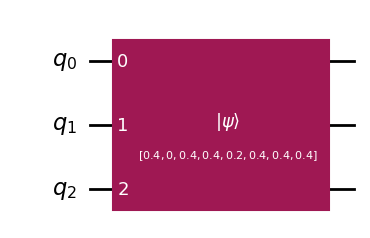

In [168]:
qc=vec_circ(np.array([1,0,1,1,0.5,1,1,1]))
qc.draw('mpl')

### Se mete bien, seguimos con otras comprobaciones
----
